In [3]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp
import scipy as sc

import lbg_forecast.priors_gp_dust as gpdp

In [4]:
ngal = 20000
n, tau, tau1, ne, taue, tau1e, sfr = gpdp.get_nagaraj22_samples(ngal)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
M

mean: 0.05356401629583033 std: 0.005924409809073202
[-3.86458333 -3.59375    -3.32291667 -3.05208333 -2.78125    -2.51041667
 -2.23958333 -1.96875    -1.69791667 -1.42708333 -1.15625    -0.88541667
 -0.61458333 -0.34375    -0.07291667  0.19791667  0.46875     0.73958333
  1.01041667  1.28125     1.55208333  1.82291667  2.09375     2.36458333] [0.6185695  0.6161121  0.61075788 0.60655638 0.59758239 0.59035293
 0.58704253 0.58535008 0.57607169 0.57361918 0.57316575 0.5665759
 0.55751775 0.55198663 0.56907112 0.62327787 0.69078753 0.73231292
 0.79956673 0.88085466 0.95661414 1.02215743 1.10118339 1.17855017] [0.09848906 0.09959483 0.09958678 0.09639167 0.09776238 0.1024276
 0.10787607 0.11420117 0.1205592  0.12818308 0.13732561 0.14565761
 0.15307446 0.16023461 0.17924697 0.2006176  0.22140757 0.18526537
 0.15423001 0.13149451 0.13677993 0.13827207 0.15194301 0.16505501]


<ErrorbarContainer object of 3 artists>

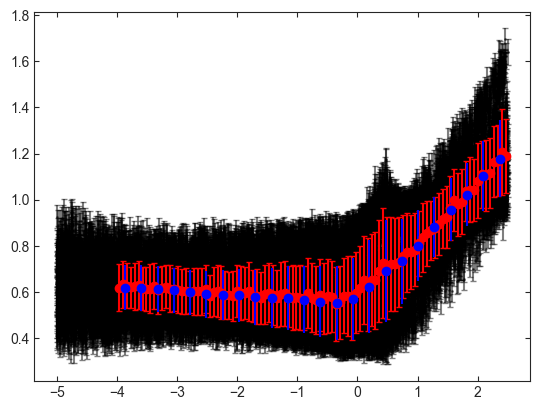

In [203]:
print("mean:", np.mean(taue), "std:", np.std(taue))
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(sfr, tau, -4, 2.5, 100)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

x, y, yerr = gpdp.process_samples_modified(sfr, tau, taue, -4, 2.5, 25)
print(x, y, yerr)
plt.errorbar(x, y, yerr, fmt='bo')

In [6]:
nsamples = 500000
recent_sfrs, dust2, dust_index, dust1 = gpdp.get_pop_cosmos_samples(nsamples)

<ErrorbarContainer object of 3 artists>

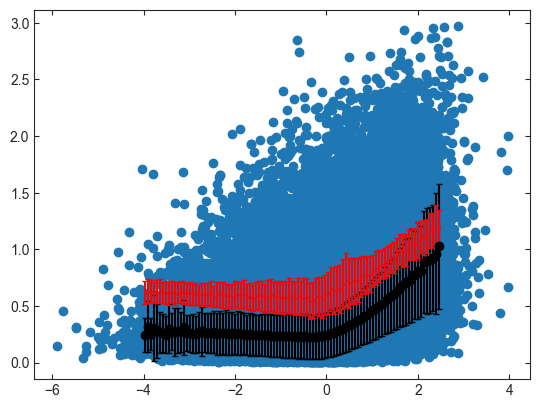

In [204]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = gpdp.process_samples(recent_sfrs, dust2, -4, 2.5, 100)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

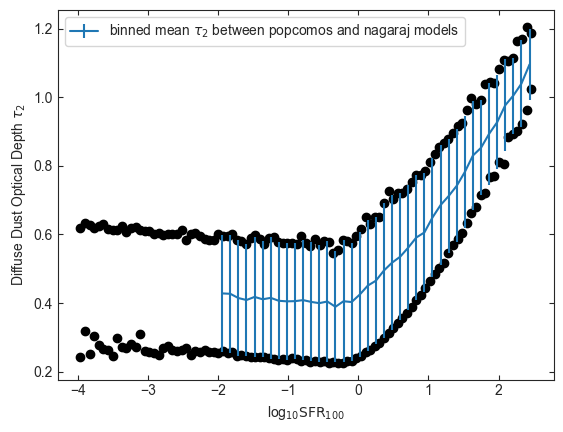

In [604]:
#x0, y0, y0err = np.array([-8]), np.array([0.5]), np.array([0.1])
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
avg_err = (bin_std + bin_std_de)/2
plt.scatter(train_sfrs, train_dust2, c='k')
x, y, yerr = gpdp.process_samples(train_sfrs, train_dust2, -2, 2.5, 40)
#x, y, yerr = gpdp.training_data_to_torch(x0, y0, y0err, x, y, yerr)
plt.errorbar(x, y, yerr, label="binned mean $\\tau_{2}$ between popcomos and nagaraj models")
plt.xlabel('log$_{10}\mathrm{SFR}_{100}$')
plt.ylabel('Diffuse Dust Optical Depth $\\tau_{2}$')
plt.legend()


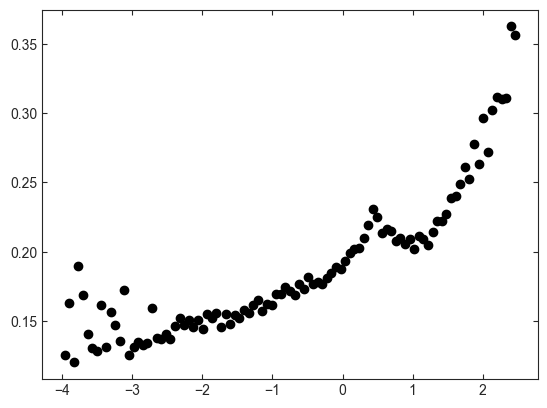

In [206]:
plt.scatter(bin_centers_de, avg_err, c='k')
#a, b, berr = gpdp.process_samples(train_sfrs, train_dust2_errs, -4, 2.5, 40)
#a, b, berr = gpdp.training_data_to_torch(x0, y0, y0err, x, y, yerr)
#plt.errorbar(a, b, berr)
#train_a, train_b, train_berr = torch.from_numpy(a), torch.from_numpy(b), torch.from_numpy(berr)

2378.5664050554174
2322.291657291712
2263.9584548483
2203.6578163847394
2141.498724256377
2077.6080629102185
2012.1302159486186
1945.226305430455
1877.0730708833307
1807.861399715605
1737.7945355484785
1667.086006444655
1595.9573269256455
1524.635534460155
1453.350624917143
1382.332953469295
1311.810666464487
1242.007224861385
1173.1390718741131
1105.413488420706
1039.026670837413
974.1620560147861
910.9889096454268
849.6611842033694
790.3166452213494
733.076257736815
678.0438195301275
625.3058239305327
574.9315323975599
526.9732356371375
481.4666815009466
438.43164815635294
397.8726418174157
359.77969951600045
324.12927879846876
290.88521771201545
259.9997498833706
231.4145608189203
205.06187273373826
180.8655462394718
158.7421880970429
138.60225498959886
120.35114391971037
103.89026041121721
89.1180562302173
75.93102886070832
64.22467550525673
53.894394953141195
44.83633128625251
36.94815408947786
30.129770603849455
24.283966106995017
19.31696971915409
15.13894380057945
11.6643961086

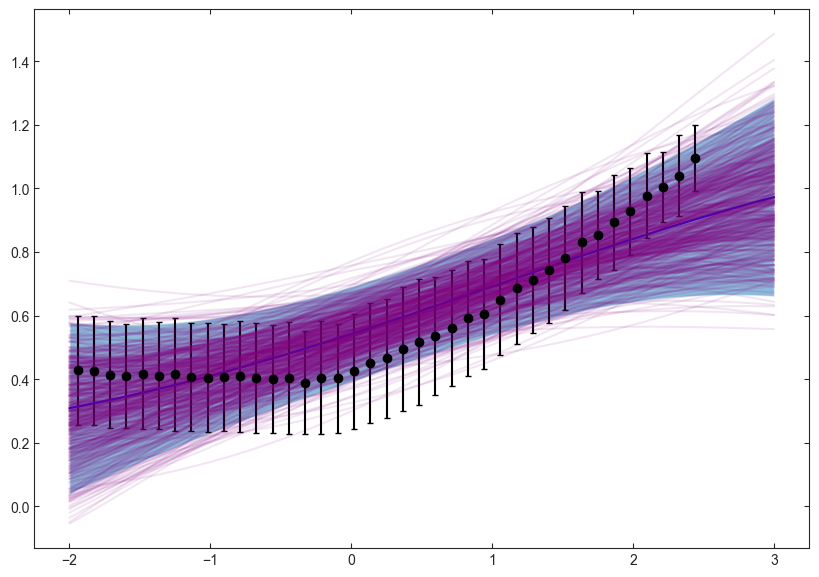

In [681]:
train_sfrs, train_dust2, train_dust2_errs = torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(yerr)
test_sfrs = torch.linspace(-2, 3, 100)
trained_model_mu, trained_likelihood_mu = gpdp.train_gp_model(train_sfrs, train_dust2, train_dust2_errs, [5.0, 15.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds_mu = gpdp.gp_evaluate_model(trained_model_mu, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_mu, test_sfrs, train_sfrs, train_dust2, train_dust2_errs, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model_mu.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_sfrs, f_preds_mu.sample().numpy(), c='purple', alpha=0.1)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


123.24756985864576
117.01481132008578
110.66785297294554
104.52996898678143
98.55003775766359
92.44632452717939
86.35072927729058
80.67168344348697
75.61214238918302
70.93943664909999
66.53153536523877
62.533322766404595
59.123313326020224
56.42000508023851
54.43298684620775
52.97647119137567
51.815327142178226
50.84933497954612
50.0903375061743
49.57306315404952
49.310690384910885
49.28656099154161
49.344349338030064
49.39131054614427
49.43353487573245
49.473930123024815
49.51371645325768
49.55319797661521
49.59218475029007
49.630235789789076
49.66680486254178
49.70133088076178
49.73329408327739
49.76225043205297
49.78785051718833
49.80984842543873
49.82810184936174
49.84256694773997
49.85328908719151
49.86039094602831
49.86405950133931
49.864532141189315
49.86208312430189
49.857011282016806
49.849628208513735
49.84024847477369
49.829181246322754
49.81672340915533
49.80315446557973
49.78873250101467
49.773691827422404
49.75824181940698
49.74256630203987
49.726824029446355
49.711149717

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


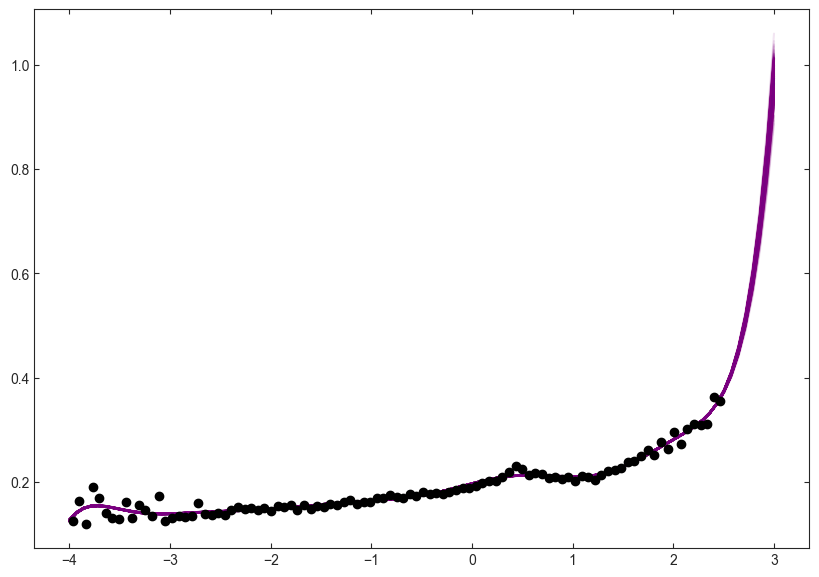

In [223]:
test_sfrs = torch.linspace(-4, 3, 100)
trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model(torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_sig, test_sfrs, torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), labelx="", labely="", alpha=0.5)

for param_name, param in trained_model_sig.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_sfrs, f_preds_sig.sample().numpy(), c='purple', alpha=0.1)

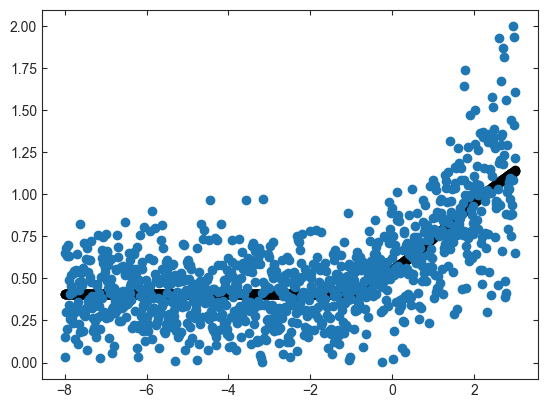

In [773]:
test_sfrs = torch.from_numpy(np.linspace(-8, 3, 1000))
f_preds_mu = gpdp.gp_evaluate_model(trained_model_mu, test_sfrs)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
mean_dust2 = f_preds_mu.sample().numpy()
mean_dust2 = np.where(test_sfrs<-1, np.interp(-1, test_sfrs, mean_dust2), mean_dust2)
sig_dust2 = f_preds_sig.sample().numpy()
sig_dust2 = np.where(sig_dust2>0.4, 0.4, sig_dust2)
sig_dust2 = np.where(test_sfrs<-1, 0.2, sig_dust2)
scatter = np.random.uniform(0.1, 0.4)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, sig_dust2, 0.0, 4.0, len(test_sfrs)))

In [8]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

In [ ]:
print("mean:", np.mean(ne), "std:", np.std(ne))

bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, n, 0, 1.5, 25)

plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

x, y, yerr = gpdp.process_samples_modified(tau, n, ne, 0.25, 1.5, 25)
plt.errorbar(x, y, yerr, fmt='bo')

In [ ]:
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust_index, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [ ]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model(train_dust2, train_dust_index, train_dust_index_errs, [2.0, 6.0], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

In [ ]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
mean_dust_index = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, scatter, -2.2, 0.4, len(test_tau)))

In [13]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')

In [ ]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)

print("mean:", np.mean(tau1e), "std:", np.std(tau1e))
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, tau1, 0.0, 1.5, 25)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

x, y, yerr = gpdp.process_samples_modified(tau, tau1, tau1e, 0.0, 1.5, 25)
plt.errorbar(x, y, yerr, fmt='bo')

In [ ]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust1, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')
plt.errorbar(x, y, yerr, fmt='bo')

In [ ]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model(train_dust2, train_dust1, train_dust1_errs, [4.0, 10.0], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(500):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.02)

In [ ]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
mean_dust1 = f_preds.sample().numpy()
scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, scatter, 0.0, 4.0, len(test_tau)))

In [18]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')